# "Airbnb Recommends" Revenue Optimization Experiment

Arlyss Gease Data-201 Capstone 1

## Introduction

This document outlines an experiment aimed to increase Airbnb company revenues by nudging guests towards underutilized high-revenue potential listings using an "Airbnb Recommends" icon to attract guests to those listings. 

This document includes:

   - Hypothesis and initial support
   - Plan for experiment and evaluation of results
   - Supporting materials for proposed test market: San Francisco 

## Hypothesis Formation

### Hypothesis to Test 
Our most basic hypothesis is that Airbnb can improve revenues by nudging users away from overutilized low-price properties towards underutilized moderate-to-high priced properties. More specifically, we propose to test the following hypothesis:

<b>Hypothesis:</b> Airbnb can increase revenue by deploying an "Airbnb Recommends" icon for display on underutilized high-satisfaction, moderate-to-high priced listings. 

We propose to test this experiment by deploying the "Airbnb Recommends" icon in one major US market: San Francisco. We have conducted a preliminary analysis of the market based on data scraped from the Airbnb website.

### Supporting Analysis
Given that Airbnb company revenue is proportionate to listing revenue, and listing revenue is driven by price and quantity of stays, directing stays towards higher-priced properties will, other things equal, increase revenue.

The best proxy for stays per listing that can be scraped from the Airbnb website is the number of reviews received by a listing. As can be seen in <b>Figure 1</b>, low-priced listings generate an outsized number of monthly reviews.

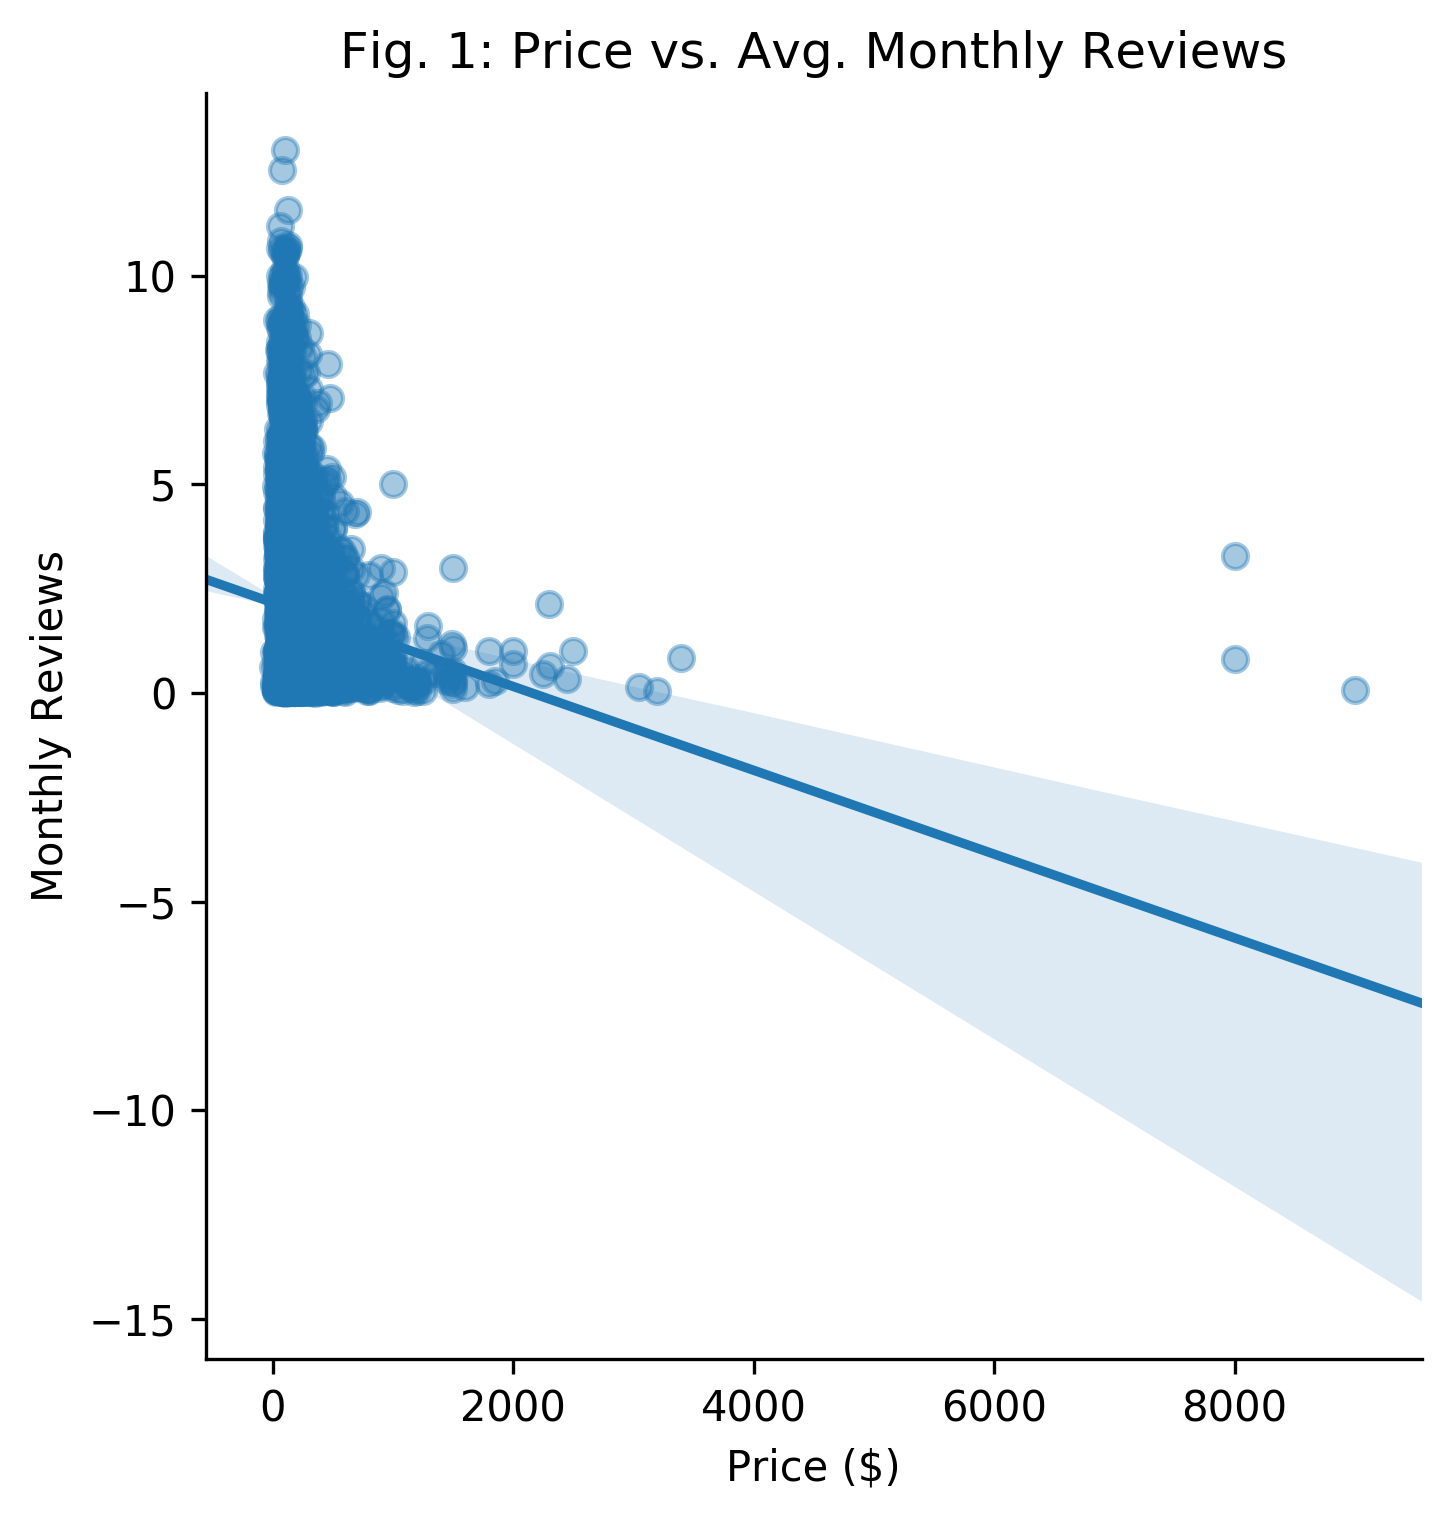

In [44]:
Image('fig_1.png', width=400, height=400)

Excluding price outliers shows a heavy concentration of reviews for listings with a daily price of less than $200 over the past 12 months (<b>Figure 2</b>).

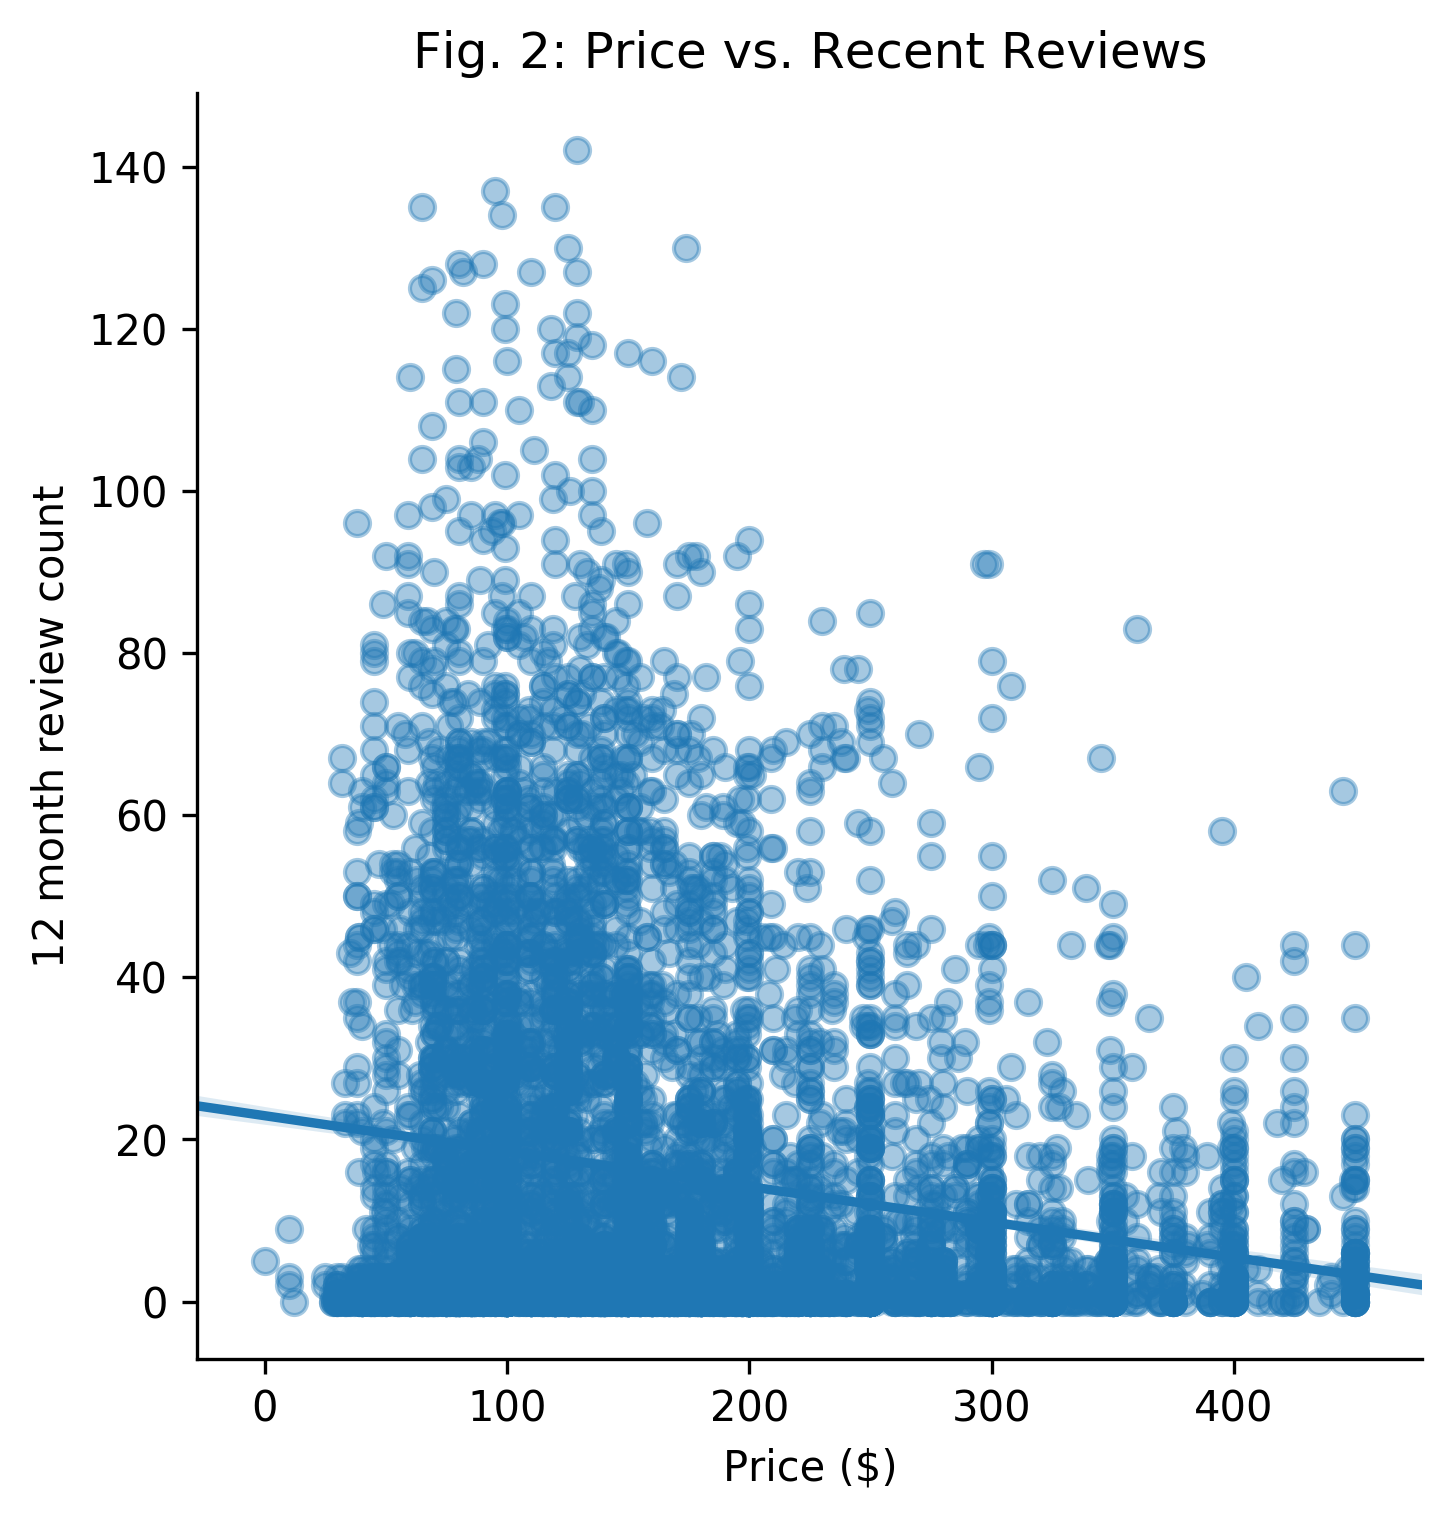

In [45]:
Image('fig_2.png', width=400, height=400)

To verify that this skew is not just due to more avilailability in lower-priced listings, we estimate utilization using the following ratio.

<b>Utilization Proxy:</b> (reviews from the <i>last</i> 12 months) / (availability in the <i>next</i> 12 months)

Since we are using different time periods for the reviews and availability, we focus our attention on the 28% of listings with an estimated utilization between 0 and 1. <b>Figure 3</b> shows lower utilization of higher-priced properties.

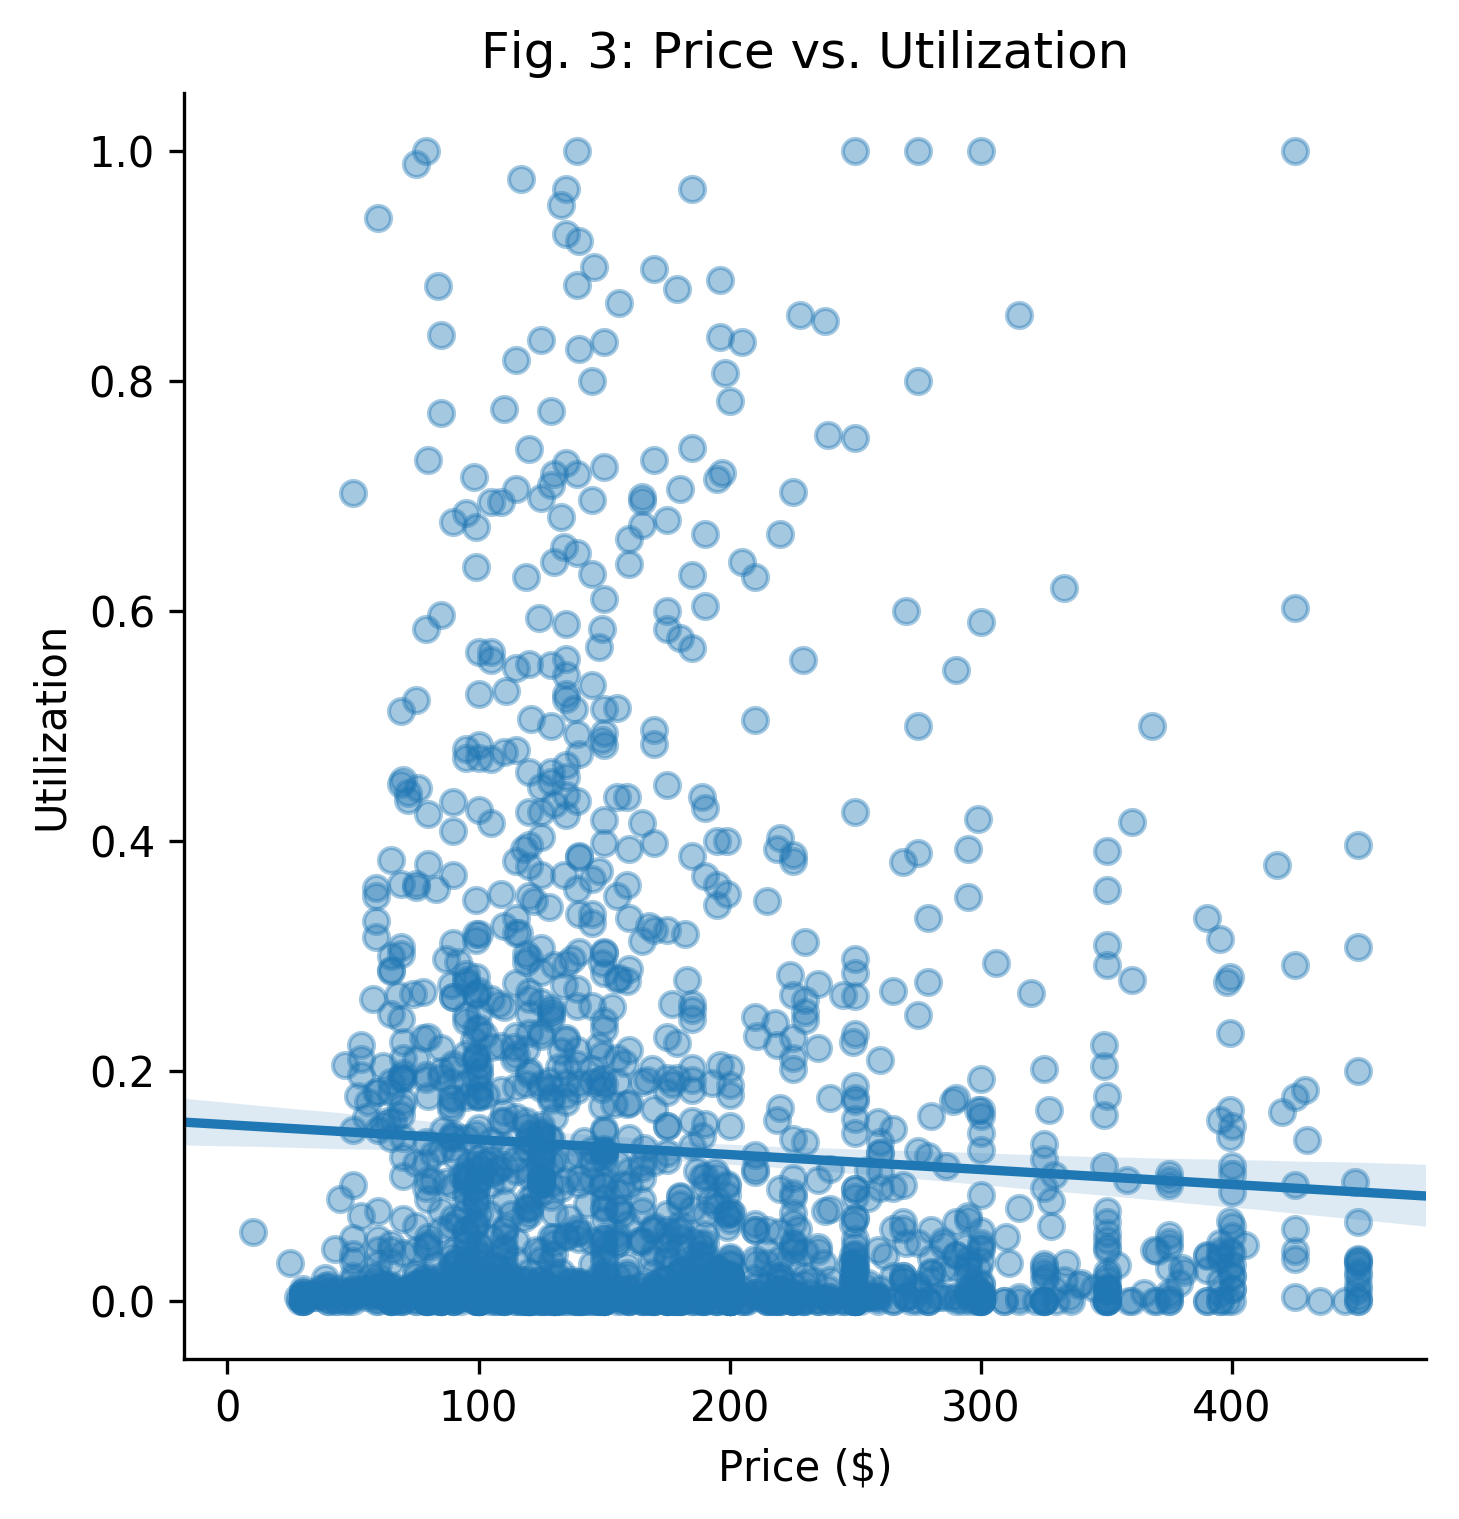

In [39]:
Image('fig_3.png', width=400, height=400)

## Experiment Proposal

We focus our proposed experiment on this population.

<b>Qualified Population:</b> A listing qualifies for the test if it meets the following three criteria.

- Daily price of at least $200
- Satisfaction score of at least 90%
- Estimated utilization below 50%

Of all listings, 34% of listings have a price greater than or equal to $200, 83% of listings have a satisfaction score above 90%, and, of listings with utilization estimates from 0 to 1, 93% have utilization of <50%. Of all listings, 9% (645) meet all three criteria. (We believe that the population could be significantly expanded if actual utilization were used in place of estimated utilization.)

After initial testing of the icon and its visibility on test accounts, we recommend randomly selecting half of the 645 qualified listings to receive an "Airbnb Recommends" icon in search results. If the qualified population could be expanded (e.g., by using actual utilization in place of our utilization proxy), we would recommend doing so in batches to avoid negative market effects.

<b>Experimental Group:</b> Random selection of 50% of qualified listings to receive an "Airbnb Recommends" icon.

<b>Control Group:</b> Remaining 50% qualified listings with no "Airbnb Recommends" icon.

For example, consider the following seeded selection:

In [79]:
seed = pd.read_csv('Experimental_Pop.csv')
seed.head()

,Unnamed: 0,listing_id,reviews_monthly,price ($),reviews_12_mo,price_outlier,availability,utilization,0to1,score,rand,Exp_Grp
0,1,5858,0.98,235.0,0,False,275,0.000000,True,98.0,0.435995,False
1,5,8567,0.28,255.0,4,False,35,0.114286,True,90.0,0.025926,False
2,8,10251,2.74,265.0,39,False,261,0.149425,True,95.0,0.549662,True
3,10,10819,0.33,218.0,0,False,275,0.000000,True,88.0,0.435322,False
4,18,14125,0.89,215.0,15,False,242,0.061983,True,98.0,0.420368,False


We recommend tracking these groups along the following dimensions:

- <b>(primary outcome)</b> number of reviews received
- listing price
- utilizaiton of availability

Each week after the initiation of the experiment, the experimental and control groups should be compared on these dimensions

- change in number of reviews in the X weeks since the experiment began and the X weeks prior
- <i>percentage</i> change in reviews in the X weeks since the experiment began and the X weeks prior
- change in listing price in the X weeks since the experiment began and the X weeks prior
- percentage change in listing price in the X weeks since the experiment began and the X weeks prior
- utilization of availability in the X weeks since the experiment began and the X weeks prior

For example, let's assume our reviews from the last 12 months are (improbably) the same as the reviews measured in the <i>n</i>th experimental period.

In [80]:
## Run our statistical test on our population's count of reviews from the past 12 months
stats.ttest_ind(seed[seed.Exp_Grp].reviews_12_mo,
                seed[seed.Exp_Grp == False].reviews_12_mo)

Ttest_indResult(statistic=0.8772216055380511, pvalue=0.38069391141960773)

The statistical difference between these samples will be insignificant. If the difference between the sample means were large and the p-value still insignificant, we would consider increasing the sample size, incorporating additional cities into the test if necessary.

## Appendix: Supporting Analyses

In [32]:
%matplotlib inline
import pandas as pd
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from datetime import date
from IPython.display import Image
import random


In [5]:
calendar = pd.read_csv('calendar (sf).csv')
listings = pd.read_csv('listings (sf).csv')
reviews  = pd.read_csv('reviews (sf).csv')

Our goal is to optimize revenue, which is driven by listing price and the number of reviews over time. First, we create a data frame to review the price and monthly reviews data from the listings table.

In [6]:
df = pd.DataFrame()
df['listing_id'] = listings['id']
df['reviews_monthly'] = listings['reviews_per_month']
df['price ($)'] = listings['price'].apply(lambda x: float(''.join(list(filter(str.isdigit, str(x))))))/100

As expected, price and monthly reviews are inversely correlated, as shown here:

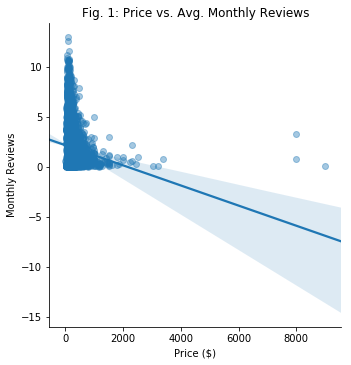

In [43]:
# Fig 1
scatter = sns.lmplot(y='reviews_monthly', x='price ($)', data=df, 
               fit_reg=True, scatter_kws={'alpha':0.4})
scatter.set_ylabels("Monthly Reviews")
scatter.set_xlabels("Price ($)")
plt.title('Fig. 1: Price vs. Avg. Monthly Reviews')
plt.savefig('fig_1.png',dpi=300, bbox_inches = 'tight')
plt.show()

To improve our analysis, we throw out high-price outliers, and count the number of reviews received in the last 12 months to ensure review volumes are up to date.

In [8]:
# add a columns to the review table to indicate year, month, and whether the review is our 12 month range
reviews['review_year'] = 0
for i in reviews.index:
    reviews.at[i,'review_year'] = int(reviews.at[i,'review_date'][-2:])
reviews['review_month'] = 0
for i in reviews.index:
    reviews.at[i,'review_month'] = int(reviews.at[i,'review_date'][:2].replace('/', ''))
reviews['12_mo_range'] = False
for i in reviews.index:
    if reviews.at[i,'review_year'] == 18 and reviews.at[i,'review_month']<10:
        reviews.at[i,'12_mo_range'] = True
    elif reviews.at[i,'review_year'] == 17 and reviews.at[i,'review_month']>9:
        reviews.at[i,'12_mo_range'] = True  

In [9]:
# add the count of reviews in the last 12 months to df
reviews_oct17_sept18 = reviews[reviews['12_mo_range']][['listing_id','id']].groupby('listing_id').aggregate('count')['id']
reviews_oct17_sept18
df['reviews_12_mo'] = 0
for i in reviews_oct17_sept18.index:
    df.at[df[df['listing_id']==i].index.tolist()[0],'reviews_12_mo'] = reviews_oct17_sept18[i]
        
#for i in df.index:
#    df.at[i,'reviews_12_mo'] = reviews_oct17_sept18[df.at[i,'listing_id']] if df.at[i,'listing_id'] in reviews_oct17_sept18.index else 0
    

In [10]:
# add a column to df indicating whether price is an outlier
q1 = df['price ($)'].quantile([.25]).tolist()[0]
q3 = df['price ($)'].quantile([.75]).tolist()[0]
price_outlier = q3 + (q3 - q1)*1.5
price_outlier
df['price_outlier'] = False
for i in df.index:
    if df.at[i,'price ($)'] > price_outlier:
        df.at[i,'price_outlier'] = True

Now we can recreate the Price vs. Reviews plot, excluding price outliers and using our count of reviews in the last year

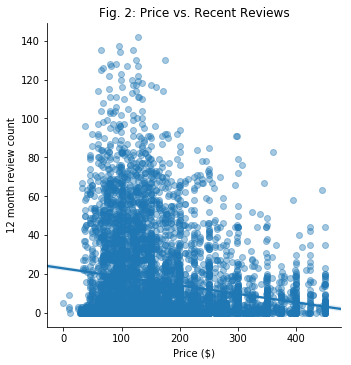

In [42]:
# Fig 2
scatter = sns.lmplot(y='reviews_12_mo', x='price ($)', data=df.where(df['price_outlier'] == False), 
               fit_reg=True, scatter_kws={'alpha':0.4})
scatter.set_ylabels("12 month review count")
scatter.set_xlabels("Price ($)")
plt.title('Fig. 2: Price vs. Recent Reviews')
plt.savefig('fig_2.png',dpi=300, bbox_inches = 'tight')
plt.show()

Next we calculate the number of days each listing has available in 2019 according to the Calendar table.

In [12]:
calendar['year'] = 0
# maybe use -1 instead of 0
for i in calendar.index:
    calendar.at[i,'year'] = int(calendar.at[i,'calendar_date'][-2:])
    
calendar_2019 = calendar[calendar['year']==19].copy()

In [13]:
calendar_2019['availa_bool'] = False
for i in calendar_2019.index:
    calendar_2019.at[i,'availa_bool'] = (calendar_2019.at[i,'available'] == 't')

In [14]:
available_2019 = calendar_2019[calendar_2019['availa_bool']][['listing_id','availa_bool']].groupby('listing_id').aggregate('count')['availa_bool']

And add estimated utilization to the analysis table

In [15]:
df['availability'] = 0
for i in available_2019.index:
        df.at[df[df['listing_id']==i].index.tolist()[0],'availability'] = available_2019[i]
df['utilization'] = df['reviews_12_mo'] / df['availability']
df['0to1'] = False
for i in df.index:
    df.at[i,'0to1'] = not( math.isnan(df.at[i,'utilization']) or math.isinf(df.at[i,'utilization']) or (df.at[i,'utilization']>1))

In [26]:
df.tail()

,listing_id,reviews_monthly,price ($),reviews_12_mo,price_outlier,availability,utilization,0to1,score
6802,28970618,NaN,71.0,0,False,0,NaN,False,NaN
6803,28979474,NaN,350.0,0,False,0,NaN,False,NaN
6804,28984696,NaN,99.0,0,False,0,NaN,False,NaN
6805,28985492,NaN,97.0,0,False,0,NaN,False,NaN
6806,28987496,NaN,55.0,0,False,0,NaN,False,NaN


In [17]:
# percentage of listings with valid utilizaiton 
df[df['0to1']].shape[0] / df.shape[0]

0.28397238137211694

In [18]:
# percentage of listings with price >= $200
df[df['price ($)'] >= 200].shape[0] / df.shape[0]

0.33876891435287204

In [19]:
df['score'] = listings['review_scores_rating']

In [20]:
# percentage of listings with review score greater than 90%
df[df['score'] >= .9].shape[0] / df['score'].shape[0]

0.8313500807991773

In [21]:
# percentage of listings with valid utilization with utilization < 50%
df[df['0to1']]['utilization'][df[df['0to1']]['utilization'] <.5].shape[0] / df[df['0to1']].shape[0]

0.9322296947749612

In [23]:
# listings meetig 
pop_size = df[(df['price ($)'] >= 200) & df['0to1'] & (df['score'] >= .9)].shape[0]
pop_percent = df[(df['price ($)'] >= 200) & df['0to1'] & (df['score'] >= .9)].shape[0]*100 / df.shape[0]

print("Population is {} or {}% of all listings".format(pop_size, pop_percent))

Population is 645 or 9.475539885412076% of all listings


In [24]:
# percentage of listings priced >= $200
df[df['price ($)'] >= 200].shape[0] / df[df['price ($)'] < 200].shape[0]

0.5123305932015108

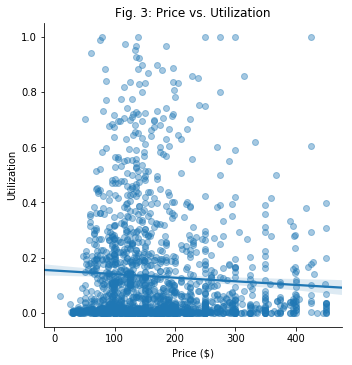

In [38]:
# Fig 3
scatter = sns.lmplot(y='utilization', x='price ($)', data=df.where(df['price_outlier'] == False).where(df['0to1'] == True), 
               fit_reg=True, scatter_kws={'alpha':0.4})
scatter.set_ylabels("Utilization")
scatter.set_xlabels("Price ($)")
plt.title('Fig. 3: Price vs. Utilization')
plt.savefig('fig_3.png',dpi=300, bbox_inches = 'tight')
plt.show()

In [72]:
## Randomly assign each qualified listing to Experiment or Control
np.random.seed(2)

Exp_Pop = df[(df['price ($)'] >= 200) & df['0to1'] & (df['score'] >= .9)].copy()
Exp_Pop['rand'] = np.random.uniform(0,1,645)

## Each listing receives a random number
Exp_Pop['Exp_Grp'] = False

## The 50th percentile of listings by random numbers are assigned to the Experimental Group 
for i in Exp_Pop.index:
    Exp_Pop.at[i,'Exp_Grp'] = ( Exp_Pop.at[i,'rand'] > Exp_Pop['rand'].median() )

Exp_Pop.to_csv('Experimental_Pop.csv')
#there are pandas libraries to do random subsetting (sample function)
#here we notice there might be two different types of availability